# Federated Learning with Self-Supervised Pre-training for HAR

This notebook demonstrates a powerful two-stage approach for Human Activity Recognition (HAR):

1.  **Self-Supervised Pre-training (SSL):** Each client first pre-trains its local model using a **contrastive learning** (SimCLR) task. This allows the model to learn robust feature representations from the raw sensor data *without using any labels*.
2.  **Federated Fine-tuning (FL):** The pre-trained models are then collaboratively fine-tuned using the standard federated learning process with labeled data.

This combination leverages the strengths of both paradigms to potentially achieve better model performance and data efficiency, while respecting data privacy. We will continue to track our key metrics for performance and privacy risk throughout the fine-tuning phase.

---

In [1]:
# --- Install Opacus for Differential Privacy ---
!pip install opacus

In [1]:
# 2
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import os
import warnings
import matplotlib.pyplot as plt
import torch.nn.functional as F
from opacus import PrivacyEngine 
from opacus.accountants import RDPAccountant # Keep for epsilon tracking, but expect 0.0000 with low noise

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Data Loading and Preprocessing

In [2]:
# 3


def load_uci_har_data(base_path):
    """Loads the UCI-HAR dataset from the specified path."""
    print("Loading UCI-HAR dataset...")

    def load_signals(folder_path, data_type='train'):
        signals = []
        # We use all 9 signals from the "Inertial Signals" folder
        signal_types = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z'
        ]
        for signal_type in signal_types:
            signal_path = os.path.join(folder_path, f'{signal_type}_{data_type}.txt')
            if os.path.exists(signal_path):
                signal = pd.read_csv(signal_path, header=None, delim_whitespace=True).values
                signals.append(signal)
            else:
                print(f"Warning: {signal_path} does not exist.")
                return None
        # Transpose to get the shape (num_samples, num_signals, sequence_length)
        return np.transpose(np.array(signals), (1, 0, 2))

    # Paths to training and testing data
    train_path = os.path.join(base_path, 'train', 'Inertial Signals')
    X_train = load_signals(train_path, data_type='train')
    y_train = pd.read_csv(os.path.join(base_path, 'train', 'y_train.txt'), header=None).values.ravel() - 1 # Labels are 1-based, convert to 0-based

    test_path = os.path.join(base_path, 'test', 'Inertial Signals')
    X_test = load_signals(test_path, data_type='test')
    y_test = pd.read_csv(os.path.join(base_path, 'test', 'y_test.txt'), header=None).values.ravel() - 1 # Labels are 1-based, convert to 0-based

    if X_train is None or X_test is None:
        raise ValueError("Failed to load UCI-HAR data. Check the file paths.")

    print(f"Loaded {len(X_train)} training samples and {len(X_test)} testing samples.")
    return torch.FloatTensor(X_train), torch.LongTensor(y_train), torch.FloatTensor(X_test), torch.LongTensor(y_test)

# --- Execute Data Loading ---
UCI_HAR_PATH = "C:\\Users\\Asus\\Desktop\\temp pro\\Federated learing\\human+activity+recognition+using+smartphones\\UCI HAR Dataset\\UCI HAR Dataset"
if not os.path.exists(UCI_HAR_PATH):
    print("Please download the UCI HAR Dataset and place it in a folder named 'UCI HAR Dataset'")
else:
    X_train, y_train, X_test, y_test = load_uci_har_data(UCI_HAR_PATH)



Loading UCI-HAR dataset...
Loaded 7352 training samples and 2947 testing samples.


Federated Learning Client Setup

In [3]:
# 4

def create_clients(X, y, num_clients=10):
    """Distributes the dataset among a number of clients."""
    print(f"Creating {num_clients} clients...")
    client_data = []
    permutation = torch.randperm(len(X))
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    
    data_per_client = len(X) // num_clients
    for i in range(num_clients):
        start = i * data_per_client
        end = (i + 1) * data_per_client
        client_data.append(TensorDataset(X_shuffled[start:end], y_shuffled[start:end]))
    print("Client creation complete.")
    return client_data

# --- Create the clients ---
NUM_CLIENTS = 10
client_datasets = create_clients(X_train, y_train, num_clients=NUM_CLIENTS)

Creating 10 clients...
Client creation complete.


Model Architecture with Projection Head (New)
For contrastive learning (SSL), we need to add a "projection head" to our CNN. This is a small multi-layer perceptron (MLP) that maps the features from the CNN to a space where the contrastive loss is applied. This head is only used during SSL pre-training and is discarded for the downstream classification task.

In [4]:
# 5


class SimpleCNN_SSL(nn.Module):
    """A simple CNN with a projection head for Self-Supervised Learning."""
    def __init__(self, num_classes=6, projection_dim=64):
        super(SimpleCNN_SSL, self).__init__()
        # --- CNN Backbone (Feature Extractor) ---
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.feature_dim = 32 * 32
        
        # --- Projection Head (for SSL only) ---
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(),
            nn.Linear(self.feature_dim, projection_dim)
        )
        
        # --- Classifier Head (for Supervised Fine-tuning) ---
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def feature_extractor_forward(self, x):
        features = self.pool(self.relu(self.conv1(x)))
        features = self.pool(self.relu(self.conv2(features)))
        features = features.view(features.size(0), -1) # Flatten
        return features

    def projection_head_forward(self, features):
        return self.projection_head(features)

    def classifier_forward(self, features):
        return self.classifier(features)

    def forward(self, x, mode='classify'):
        # Pass input through the CNN backbone
        features = self.feature_extractor_forward(x)

        if mode == 'pretext':
            # For SSL, return the output of the projection head
            return self.projection_head_forward(features)
        else: # mode == 'classify' or default
            # For classification, return the output of the classifier head
            return self.classifier_forward(features)

In [5]:
# 6


# --- 1. Data Augmentation for Time Series ---
def augment_data(x):
    """Applies simple augmentations: noise and scaling."""
    noise = torch.randn_like(x) * 0.05
    scale = torch.randn(1).item() * 0.1 + 1.0
    return (x + noise) * scale

# --- 2. Contrastive Loss (InfoNCE Loss) ---
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, features):
        # features shape: [2 * batch_size, projection_dim]
        batch_size = features.shape[0] // 2
        
        # Normalize features to lie on the unit hypersphere
        features = F.normalize(features, dim=1)
        
        # Create similarity matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature
        
        # Create labels for the loss function
        # The positive pairs are (i, i+batch_size) and (i+batch_size, i)
        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        
        # Mask out diagonal (self-similarity)
        mask = torch.eye(labels.shape[0], dtype=torch.bool)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        
        # Select positive pairs
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        
        # Select negative pairs
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
        
        logits = torch.cat([positives, negatives], dim=1)
        # The positive sample is always at index 0
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=features.device)
        
        return self.criterion(logits, labels)

# --- 3. Client SSL Pre-training Loop ---
def client_ssl_pretrain(client_model, train_loader, epochs=10, device='cpu'):
    """Pre-trains a client's model using a self-supervised contrastive task."""
    client_model.to(device)
    client_model.train()
    
    optimizer = optim.Adam(client_model.parameters(), lr=0.001)
    ssl_loss_fn = InfoNCELoss().to(device)
    
    print("Starting SSL Pre-training...")
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader: # We don't need labels for SSL
            data = data.to(device)
            
            # Create two augmented views of the data
            aug1 = augment_data(data)
            aug2 = augment_data(data)
            
            # Combine the augmented views into a single batch
            combined_data = torch.cat([aug1, aug2], dim=0)
            
            optimizer.zero_grad()
            
            # Get projected features from the model
            projections = client_model(combined_data, mode='pretext')
            
            # Calculate the contrastive loss
            loss = ssl_loss_fn(projections)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        print(f"SSL Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
    print("SSL Pre-training complete.")
    return client_model.state_dict()

Federated Fine-Tuning and Aggregation Functions

In [6]:
#7
import torch.nn.functional as F
from opacus import PrivacyEngine
from opacus.grad_sample import GradSampleModule, wrap_model # Import GradSampleModule and wrap_model

# The corrected DP-enabled training function
def train_client_with_dp(model, train_loader, optimizer, device, epochs=1, noise_multiplier=1.0, max_grad_norm=1.0, delta=1e-5):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    
    # A new privacy engine is created for the model in each round.
    privacy_engine = PrivacyEngine()

    try:
        # The main change is setting poisson_sampling=False for better robustness.
        # The PrivacyEngine will now use uniform sampling without replacement.
        private_model, private_optimizer, private_train_loader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier=noise_multiplier,
            max_grad_norm=max_grad_norm,
            poisson_sampling=False, # Changed toz False for robustness
        )

        for epoch in range(epochs):
            for data, target in private_train_loader:
                data, target = data.to(device), target.to(device)
                private_optimizer.zero_grad()
                output = private_model(data, mode='classify')
                loss = criterion(output, target)
                loss.backward()
                private_optimizer.step()
        
        epsilon = privacy_engine.get_epsilon(delta=delta)
        print(f"Privacy budget: ε = {epsilon:.2f}")
        
        # The model object is modified by the PrivacyEngine.
        # It will be discarded and replaced in the main loop, so no detach is needed.
        return model.state_dict(), epsilon

    except Exception as e:
        # This fallback is still useful in case other errors occur
        print(f"Error making private: {e}. Falling back to non-DP training for this client.")
        for epoch in range(epochs):
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data, mode='classify')
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        return model.state_dict(), None

# Original non-DP finetuning function (kept for reference)
def client_finetune_update(client_model, optimizer, train_loader, epochs=5, device='cpu'):
    client_model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data, mode='classify')
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return client_model.state_dict()

def get_masked_update(model, mask_seed):
    torch.manual_seed(mask_seed)
    mask = {}
    for k, v in model.state_dict().items():
        mask[k] = torch.randn_like(v, device=v.device)
    masked_update = {k: v + mask[k] for k, v in model.state_dict().items()}
    return masked_update, mask

def server_aggregate(global_model, masked_updates, masks):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        if 'projection_head' in k:
            continue
        agg = sum([update[k].float().to(global_dict[k].device) for update in masked_updates])
        agg -= sum([mask[k].float().to(global_dict[k].device) for mask in masks])
        global_dict[k] = agg / len(masked_updates)
    global_model.load_state_dict(global_dict)
    return global_model


Metrics and Risk Simulation Functions

In [7]:
#8


def calculate_communication_overhead(model):
    """Calculates the size of the model in megabytes (MB)."""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return (param_size + buffer_size) / 1024**2

def simulate_gradient_leakage(client_model, original_data, original_target, device='cpu'):
    """Simulates a basic gradient leakage attack (Deep Leakage from Gradients).
    This simulation is for demonstration and might not fully reflect the effectiveness
    of DP against such attacks, as Opacus adds noise to the gradients before they leave the client.
    However, it still serves as a proxy for how much information could be leaked from an un-noised gradient.
    When DP is active, the gradients are inherently noisy, making this attack much harder."""
    original_data, original_target = original_data.to(device), original_target.to(device)

    # Get the original gradients from the client's update
    # We create a dummy model to get gradients in a non-DP context for the attack simulation
    # This means this attack simulation will assess the 'leakage potential' if DP were NOT applied,
    # or if an attacker could somehow reverse the DP noise.
    original_model = SimpleCNN_SSL().to(device)
    original_model.load_state_dict(client_model.state_dict())
    optimizer = optim.SGD(original_model.parameters(), lr=0.1) # Optimizer for gradient calculation
    optimizer.zero_grad()
    
    # Ensure we are in 'classify' mode for the downstream task
    original_output = original_model(original_data, mode='classify')
    original_loss = nn.CrossEntropyLoss()(original_output, original_target)
    original_loss.backward()
    
    # Filter out None gradients for unused parameters (like the projection head)
    original_gradients = [param.grad.clone() for param in original_model.parameters() if param.grad is not None]

    # Initialize a "dummy" input and label to be optimized
    dummy_data = torch.randn(original_data.size(), requires_grad=True, device=device)
    dummy_target = torch.randint(0, 6, (original_target.size(0),), device=device)

    attack_optimizer = optim.LBFGS([dummy_data], lr=1.0)
    
    history = []
    for _ in range(10): # Attack iterations
        def closure():
            attack_optimizer.zero_grad()
            
            dummy_model = SimpleCNN_SSL().to(device)
            dummy_model.load_state_dict(client_model.state_dict()) # Use the client model's weights
            
            # Ensure we are in 'classify' mode for the attack
            dummy_output = dummy_model(dummy_data, mode='classify')
            dummy_loss = nn.CrossEntropyLoss()(dummy_output, dummy_target)

            # CORRECTED PART: Added allow_unused=True
            dummy_gradients = torch.autograd.grad(dummy_loss, dummy_model.parameters(), create_graph=True, allow_unused=True)
            # Filter out None gradients to match the original_gradients list
            dummy_gradients = [grad for grad in dummy_gradients if grad is not None]
            
            gradient_diff = 0
            for original_grad, dummy_grad in zip(original_gradients, dummy_gradients):
                 gradient_diff += ((original_grad - dummy_grad)**2).sum()

            gradient_diff.backward()
            return gradient_diff
        
        attack_optimizer.step(closure)
        current_loss = closure().item()
        history.append(current_loss)

    # Return the minimum loss achieved by the attack
    return min(history) if history else float('inf')


def simulate_membership_inference(global_model, member_loader, non_member_loader, device='cpu'):
    """Simulates a basic membership inference attack.
    This attack aims to determine if a data point was part of the training set.
    Differential Privacy aims to reduce the success rate of such an attack,
    bringing the attack accuracy closer to random guessing (0.5)."""
    global_model.eval() # Ensure model is in eval mode for consistent predictions

    member_outputs = []
    with torch.no_grad():
        for data, _ in member_loader:
            data = data.to(device)
            member_outputs.append(global_model(data, mode='classify').cpu())
    if member_outputs: # Check if list is not empty
        member_outputs = torch.cat(member_outputs)
    else:
        member_outputs = torch.tensor([]) # Handle empty case

    non_member_outputs = []
    with torch.no_grad():
        for data, _ in non_member_loader:
            data = data.to(device)
            non_member_outputs.append(global_model(data, mode='classify').cpu())
    if non_member_outputs: # Check if list is not empty
        non_member_outputs = torch.cat(non_member_outputs)
    else:
        non_member_outputs = torch.tensor([]) # Handle empty case

    # Only proceed if both member and non-member outputs have data
    if member_outputs.numel() == 0 and non_member_outputs.numel() == 0:
        return 0.5 # Cannot perform attack, assume random guess

    # Combine outputs and create labels for the attack model
    attack_X = []
    attack_y = []

    if member_outputs.numel() > 0:
        attack_X.append(member_outputs)
        member_labels = torch.ones(len(member_outputs))
        attack_y.append(member_labels)

    if non_member_outputs.numel() > 0:
        attack_X.append(non_member_outputs)
        non_member_labels = torch.zeros(len(non_member_outputs))
        attack_y.append(non_member_labels)
    
    if not attack_X: # If no data to form attack_X, return 0.5
        return 0.5

    attack_X = torch.cat(attack_X)
    attack_y = torch.cat(attack_y)

    # Check for empty attack dataset
    if len(attack_X) == 0:
        return 0.5 # Return 0.5 if no data for the attack model

    attack_dataset = TensorDataset(attack_X, attack_y)
    attack_loader = DataLoader(attack_dataset, batch_size=32, shuffle=True)
    
    attack_model = nn.Sequential(
        nn.Linear(6, 16), # Assuming 6 classes for HAR, so output of global_model is 6-dimensional
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    ).to(device)
    
    attack_optimizer = optim.Adam(attack_model.parameters(), lr=0.01)
    attack_criterion = nn.BCELoss()
    
    for epoch in range(10): # Train the attack model
        for data, target in attack_loader:
            data, target = data.to(device), target.to(device)
            attack_optimizer.zero_grad()
            output = attack_model(data)
            loss = attack_criterion(output, target.unsqueeze(1))
            loss.backward()
            attack_optimizer.step()
            
    attack_model.eval() # Evaluate the attack model
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in attack_loader:
            data, target = data.to(device), target.to(device)
            output = attack_model(data)
            predicted = (output > 0.5).float()
            correct += (predicted == target.unsqueeze(1)).sum().item()
            total += target.size(0)
            
    return correct / total if total > 0 else 0.5 # Avoid division by zero

Main Training Loop

In [8]:
import itertools
import random  # import random for sampling

# --- Parameters ---
SSL_PRETRAIN_EPOCHS = 20
COMMUNICATION_ROUNDS = 25
CLIENT_FINETUNE_EPOCHS = 3
BATCH_SIZE = 48
LEARNING_RATE = 0.001
# DP Parameters (tuned for a balance between privacy and utility)
DP_NOISE_MULTIPLIER = 1.2 
DP_MAX_GRAD_NORM = 0.4   
DP_DELTA = 1e-5          
FRACTION_PARTICIPANTS = 0.3  # 30% clients per round

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Initialize Models for each client ---
client_models = [SimpleCNN_SSL().to(device) for _ in range(NUM_CLIENTS)]

# --- STAGE 1: Self-Supervised Pre-training on each client ---
for i in range(NUM_CLIENTS):
    print(f"\n--- Pre-training Client {i+1}/{NUM_CLIENTS} ---")
    client_loader = DataLoader(client_datasets[i], batch_size=BATCH_SIZE, shuffle=True)
    pre_trained_state = client_ssl_pretrain(client_models[i], client_loader, epochs=SSL_PRETRAIN_EPOCHS, device=device)
    client_models[i].load_state_dict(pre_trained_state)

# --- Initialize Global Model ---
global_model = SimpleCNN_SSL().to(device)
global_model.load_state_dict(client_models[0].state_dict())

# --- STAGE 2: Federated Fine-tuning Loop with DP ---
print("\n\n--- Starting Federated Fine-tuning with DP (Cross-Device) ---")

# --- Logging ---
accuracies = []
f1_scores = []
comm_overheads = []
grad_risks = []
mem_inf_risks = []
epsilons = []

for round_num in range(COMMUNICATION_ROUNDS):
    print(f"\n--- Communication Round {round_num + 1}/{COMMUNICATION_ROUNDS} ---")

    # --- Cross-device: sample subset of clients ---
    num_participants = max(1, int(FRACTION_PARTICIPANTS * NUM_CLIENTS))
    sampled_client_indices = random.sample(range(NUM_CLIENTS), num_participants)

    client_updates = []
    round_epsilons = []

    for i in sampled_client_indices:
        client_models[i] = SimpleCNN_SSL().to(device)  # Create fresh model for client i
        client_models[i].load_state_dict(global_model.state_dict())  # Load global weights

        print(f"Client {i+1} training...")

        client_loader = DataLoader(client_datasets[i], batch_size=BATCH_SIZE, shuffle=True)

        # Optimize only 'classify' parts: conv1, conv2, classifier (exclude projection_head)
        trainable_params = itertools.chain(
            client_models[i].conv1.parameters(),
            client_models[i].conv2.parameters(),
            client_models[i].classifier.parameters()
        )
        optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)

        # DP training call
        update, epsilon_val = train_client_with_dp(
            client_models[i],
            client_loader,
            optimizer,
            device,
            epochs=CLIENT_FINETUNE_EPOCHS,
            noise_multiplier=DP_NOISE_MULTIPLIER,
            max_grad_norm=DP_MAX_GRAD_NORM,
            delta=DP_DELTA
        )
        client_updates.append(update)
        if epsilon_val is not None:
            round_epsilons.append(epsilon_val)

    epsilons.append(round_epsilons[0] if round_epsilons else 0.0)

    # --- Server aggregation over sampled clients' updates ---
    masked_updates = []
    masks = []
    for idx, client_model_state in enumerate(client_updates):
        client_id = sampled_client_indices[idx]
        temp_model = SimpleCNN_SSL().to(device)
        temp_model.load_state_dict(client_model_state)
        masked_update, mask = get_masked_update(temp_model, mask_seed=client_id + 1)
        masked_updates.append(masked_update)
        masks.append(mask)

    global_model = server_aggregate(global_model, masked_updates, masks)

    # Broadcast aggregated global model to all clients for next round
    for i in range(NUM_CLIENTS):
        client_models[i].load_state_dict(global_model.state_dict())

    # --- Evaluation ---
    global_model.eval()
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data, mode='classify')
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracies.append(accuracy)
    f1_scores.append(f1)

    communication_overhead = calculate_communication_overhead(global_model)
    comm_overheads.append(communication_overhead)

    # --- Privacy Risk Simulation ---
    sample_client_idx = 0
    if len(client_datasets[sample_client_idx]) > 0:
        sample_data, sample_target = client_datasets[sample_client_idx][0:1]
        grad_risk = simulate_gradient_leakage(client_models[sample_client_idx], sample_data, sample_target, device=device)
    else:
        grad_risk = float('inf')
    grad_risks.append(grad_risk)

    member_loader_mia = DataLoader(client_datasets[sample_client_idx], batch_size=BATCH_SIZE)
    non_member_loader_mia = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)
    mem_inf_risk = simulate_membership_inference(global_model, member_loader_mia, non_member_loader_mia, device=device)
    mem_inf_risks.append(mem_inf_risk)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Communication Overhead (per client): {communication_overhead:.4f} MB")
    print(f"Gradient Leakage Risk: {grad_risk:.4f}")  # lower is worse for attacker
    print(f"Membership Inference Risk: {mem_inf_risk:.4f}")  # higher is worse for privacy
    if round_epsilons:
        print(f"Epsilon for client {sample_client_idx+1} at this round: {round_epsilons[0]:.2f}")


Using device: cpu

--- Pre-training Client 1/10 ---
Starting SSL Pre-training...
SSL Epoch [1/20], Loss: 3.6319
SSL Epoch [2/20], Loss: 3.1091
SSL Epoch [3/20], Loss: 2.9790
SSL Epoch [4/20], Loss: 2.9183
SSL Epoch [5/20], Loss: 2.8866
SSL Epoch [6/20], Loss: 2.8654
SSL Epoch [7/20], Loss: 2.8311
SSL Epoch [8/20], Loss: 2.8093
SSL Epoch [9/20], Loss: 2.8026
SSL Epoch [10/20], Loss: 2.7883
SSL Epoch [11/20], Loss: 2.7762
SSL Epoch [12/20], Loss: 2.7644
SSL Epoch [13/20], Loss: 2.7745
SSL Epoch [14/20], Loss: 2.7498
SSL Epoch [15/20], Loss: 2.7323
SSL Epoch [16/20], Loss: 2.7367
SSL Epoch [17/20], Loss: 2.7206
SSL Epoch [18/20], Loss: 2.7261
SSL Epoch [19/20], Loss: 2.7050
SSL Epoch [20/20], Loss: 2.6917
SSL Pre-training complete.

--- Pre-training Client 2/10 ---
Starting SSL Pre-training...
SSL Epoch [1/20], Loss: 3.4575
SSL Epoch [2/20], Loss: 3.0222
SSL Epoch [3/20], Loss: 2.9533
SSL Epoch [4/20], Loss: 2.9007
SSL Epoch [5/20], Loss: 2.8791
SSL Epoch [6/20], Loss: 2.8316
SSL Epoch [7

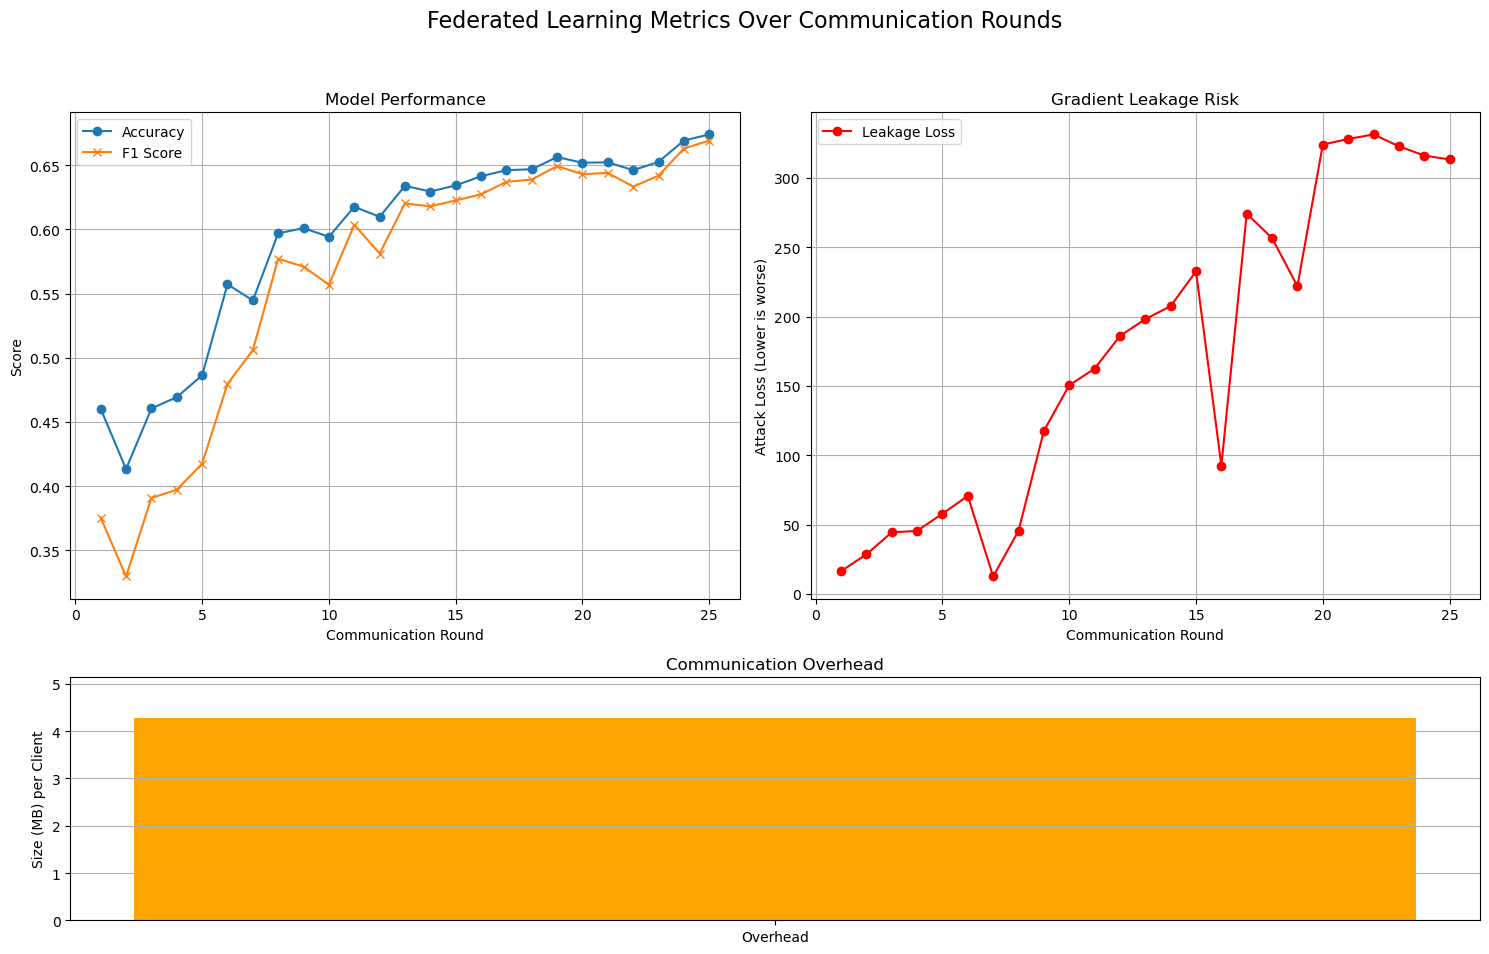

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])
fig.suptitle('Federated Learning Metrics Over Communication Rounds', fontsize=16)

# Top-left: Accuracy and F1
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', marker='o')
ax0.plot(range(1, len(f1_scores) + 1), f1_scores, label='F1 Score', marker='x')
ax0.set_title('Model Performance')
ax0.set_xlabel('Communication Round')
ax0.set_ylabel('Score')
ax0.legend()
ax0.grid(True)

# Top-right: Gradient Leakage
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(range(1, len(grad_risks) + 1), grad_risks, label='Leakage Loss', marker='o', color='red')
ax1.set_title('Gradient Leakage Risk')
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Attack Loss (Lower is worse)')
ax1.legend()
ax1.grid(True)

# Bottom (centered): Communication Overhead
ax2 = fig.add_subplot(gs[1, :])  # Span both columns
ax2.bar(['Overhead'], [comm_overheads[0] if comm_overheads else 0], color='orange')
ax2.set_title('Communication Overhead')
ax2.set_ylabel('Size (MB) per Client')
ax2.set_ylim(0, (comm_overheads[0] if comm_overheads else 0) * 1.2)
ax2.grid(True, axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
